In [152]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

In [153]:
d1 = pd.read_csv("C:\ENGR 418 project\data.csv")

In [154]:
d1.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [155]:
#We need to remove columns which are not required for this project
d2 = d1.drop(['id','date', 'condition', 'sqft_lot','waterfront','view','grade','sqft_above', 'sqft_basement','yr_renovated','lat','long','sqft_living15','sqft_lot15'],axis='columns')
d2.shape

(21613, 7)

In [156]:
d2.columns #Now we should have the data set we want to use

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'yr_built',
       'zipcode'],
      dtype='object')

In [157]:
d3 = d2.dropna() #Dropping all NA values to remove unusable data points
d3.isnull().sum() #We should have no null values.

price          0
bedrooms       0
bathrooms      0
sqft_living    0
floors         0
yr_built       0
zipcode        0
dtype: int64

In [158]:
# Feature engineering -> Changing the feature 'price' to have CAD values instead of USD
d3.insert(1, 'price_cad', '-')
d3.price_cad = d3.price * 1.31
d3.head(3)

,price,price_cad,bedrooms,bathrooms,sqft_living,floors,yr_built,zipcode
0,221900.0,290689.0,3,1.00,1180,1.0,1955,98178
1,538000.0,704780.0,3,2.25,2570,2.0,1951,98125
2,180000.0,235800.0,2,1.00,770,1.0,1933,98028


In [159]:
d4 = d3.drop('price', axis='columns') #We do not need the old price column
d4.head(3)

,price_cad,bedrooms,bathrooms,sqft_living,floors,yr_built,zipcode
0,290689.0,3,1.00,1180,1.0,1955,98178
1,704780.0,3,2.25,2570,2.0,1951,98125
2,235800.0,2,1.00,770,1.0,1933,98028


In [160]:
d4.insert(1, 'price_per_sqft', '-') #Feature addition, adding a new column for price per sqft
d4.price_per_sqft = d4.price_cad / d4.sqft_living
d4.head(3)

,price_cad,price_per_sqft,bedrooms,bathrooms,sqft_living,floors,yr_built,zipcode
0,290689.0,246.346610,3,1.00,1180,1.0,1955,98178
1,704780.0,274.233463,3,2.25,2570,2.0,1951,98125
2,235800.0,306.233766,2,1.00,770,1.0,1933,98028


In [161]:
d4.to_csv("milestone_1_1.csv",index=False) # for testing

In [162]:
#Any location having less than 100 data points should be tagged as "other" location.
d4.zipcode = d4.zipcode.apply(lambda x: str(x).strip())
count_zip = d4['zipcode'].value_counts(ascending=False)
count_zip

98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [163]:
len(count_zip[count_zip<=100])

4

In [164]:
other_zip = count_zip[count_zip<=100]
other_zip

98010    100
98024     81
98148     57
98039     50
Name: zipcode, dtype: int64

In [165]:
d4.zipcode = d4.zipcode.apply(lambda x: 'other' if x in other_zip else x)
# The zipcodes with less than 100 data points are now removed.

In [166]:
d5 = d4.copy()

In [167]:
d5.price_per_sqft.describe() #Statistics for data analysis

count    21613.000000
mean       346.045138
std        144.179639
min        114.740588
25%        238.802083
50%        320.484360
75%        417.003106
max       1061.281944
Name: price_per_sqft, dtype: float64

In [168]:
# Here we find the minimum price is 114 and max is 1061 which shows a wide variance in data. We may need to remove outliers.
def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('zipcode'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
d6 = remove_outliers(d5)
d6.shape

(16540, 8)

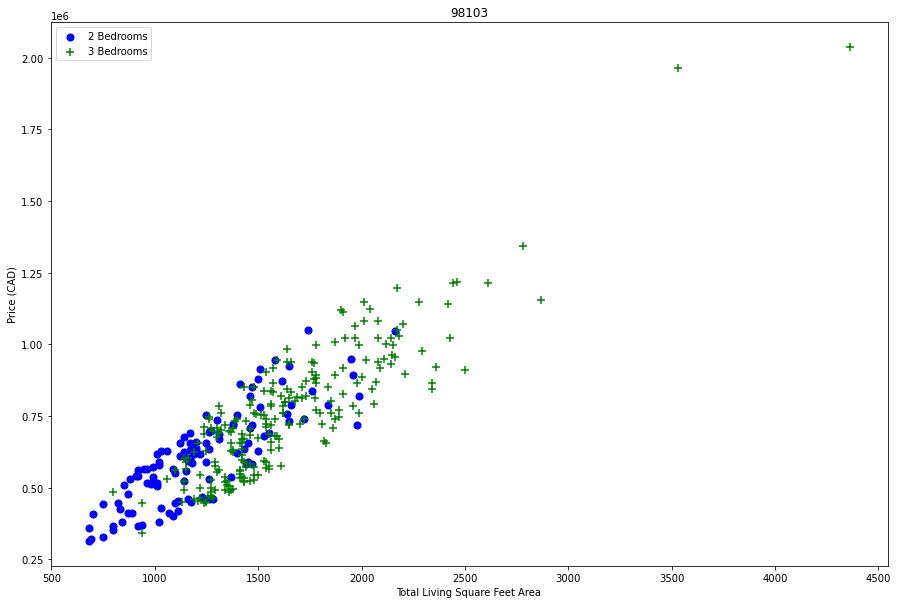

In [169]:
# Let's check if for a given zipcode (98103) how the 2 and 3 bedroom property prices look like
def plot_scatter_chart(d,zipcode):
    b2 = d[(d.zipcode==zipcode) & (d.bedrooms==2)]
    b3 = d[(d.zipcode==zipcode) & (d.bedrooms==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(b2.sqft_living,b2.price_cad,color='blue',label='2 Bedrooms', s=50)
    plt.scatter(b3.sqft_living,b3.price_cad,marker='+', color='green',label='3 Bedrooms', s=50)
    plt.xlabel("Total Living Square Feet Area")
    plt.ylabel("Price (CAD)")
    plt.title(zipcode)
    plt.legend()
    
plot_scatter_chart(d6,"98103")

Text(0, 0.5, 'Count')

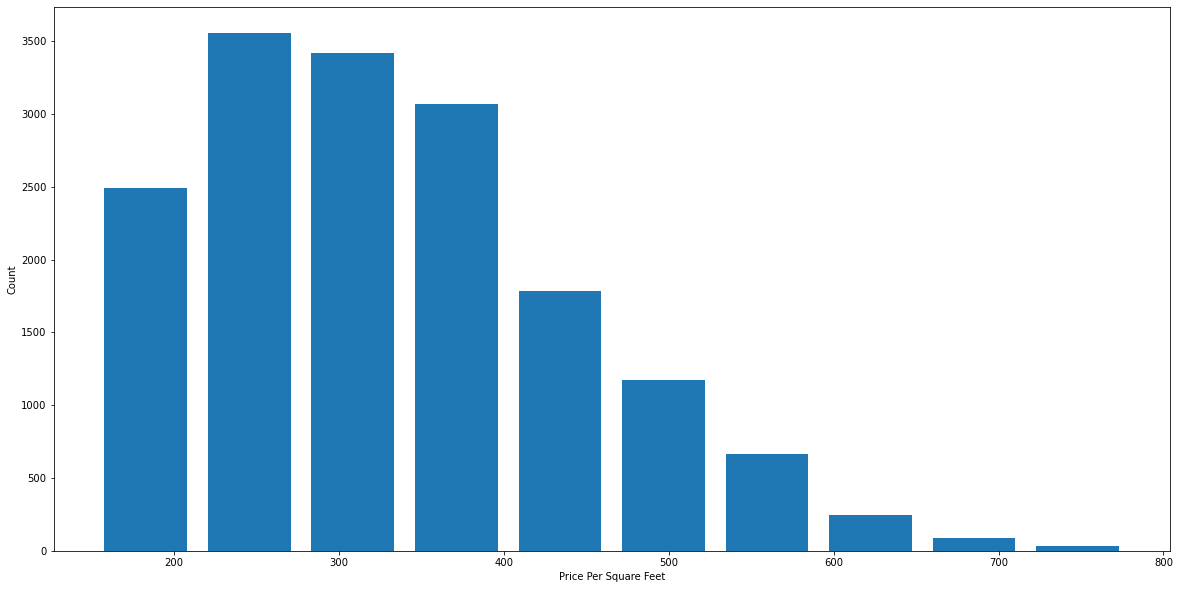

In [170]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(d6.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [171]:
d6.bathrooms.unique()

array([2.5 , 2.  , 1.5 , 1.75, 1.  , 2.75, 2.25, 3.  , 0.  , 0.75, 3.5 ,
       5.  , 3.25, 4.  , 3.75, 6.  , 5.5 , 4.25, 4.5 , 4.75, 5.25, 6.75,
       5.75, 0.5 , 1.25, 6.25])

In [172]:
d6_1 = d6.drop(['price_per_sqft'],axis='columns')
d6_1

,price_cad,bedrooms,bathrooms,sqft_living,floors,yr_built,zipcode
0,375970.0,4,2.50,2240,2.0,2005,98001
1,628800.0,4,2.50,3230,2.0,2001,98001
2,609150.0,3,2.50,2714,2.0,2005,98001
3,471600.0,4,2.50,2160,2.0,1992,98001
4,301300.0,3,2.00,1450,1.0,2003,98001
...,...,...,...,...,...,...,...
16535,943200.0,3,2.50,3150,2.0,2007,other
16536,576400.0,4,2.50,2990,2.0,2011,other
16537,435208.2,3,1.50,2580,1.0,1953,other
16538,1911290.0,4,4.00,4620,2.0,2014,other


In [173]:
d7 = d6_1.copy()
# using one hot encoding
dummies = pd.get_dummies(d7.zipcode)
dummies.head(3)

,98001,98002,98003,98004,98005,98006,98007,98008,98011,98014,...,98146,98155,98166,98168,98177,98178,98188,98198,98199,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
d8 = pd.concat([d7,dummies.drop('other',axis='columns')],axis='columns')
d8.head()

,price_cad,bedrooms,bathrooms,sqft_living,floors,yr_built,zipcode,98001,98002,98003,...,98144,98146,98155,98166,98168,98177,98178,98188,98198,98199
0,375970.0,4,2.5,2240,2.0,2005,98001,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,628800.0,4,2.5,3230,2.0,2001,98001,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,609150.0,3,2.5,2714,2.0,2005,98001,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,471600.0,4,2.5,2160,2.0,1992,98001,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,301300.0,3,2.0,1450,1.0,2003,98001,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
d9 = d8.drop('zipcode',axis='columns')
d9.head(3)

,price_cad,bedrooms,bathrooms,sqft_living,floors,yr_built,98001,98002,98003,98004,...,98144,98146,98155,98166,98168,98177,98178,98188,98198,98199
0,375970.0,4,2.5,2240,2.0,2005,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,628800.0,4,2.5,3230,2.0,2001,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,609150.0,3,2.5,2714,2.0,2005,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
d9.shape

(16540, 72)

In [177]:
X = d9.drop(['price_cad'],axis='columns')
X.head(10)

,bedrooms,bathrooms,sqft_living,floors,yr_built,98001,98002,98003,98004,98005,...,98144,98146,98155,98166,98168,98177,98178,98188,98198,98199
0,4,2.50,2240,2.0,2005,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2.50,3230,2.0,2001,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2.50,2714,2.0,2005,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2.50,2160,2.0,1992,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2.00,1450,1.0,2003,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,1.50,1550,1.0,1969,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,1.50,1670,1.0,1954,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,4,2.50,2250,1.0,1982,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3,1.75,1450,1.0,1981,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,2.00,1400,1.0,1974,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
X.shape

(16540, 71)

In [179]:
y = d9.price_cad
y.head(10)

0    375970.0
1    628800.0
2    609150.0
3    471600.0
4    301300.0
5    330120.0
6    298614.5
7    399550.0
8    318330.0
9    305230.0
Name: price_cad, dtype: float64

In [180]:
len(y)

16540

In [181]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [182]:
from sklearn.linear_model import LinearRegression
mod = LinearRegression()
mod.fit(X_train,y_train)
mod.score(X_test,y_test)

0.8778813650025634

In [183]:
#Use K Fold cross validation to measure accuracy of our LinearRegression model
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

arr = cross_val_score(LinearRegression(), X, y, cv=cv)
arr * 100

array([87.70718051, 88.06824389, 87.98141068, 87.85224231, 87.90256028,
       87.28780604, 86.62168084, 88.24999562, 88.24380905, 87.80977693])

In [184]:
# We get more than 87 percent success rate in 5 iterations
# Lets test the model manually
def predict_price(bedrooms, bathrooms, sqft_living, floors, yr_built, zipcode):    
    index = np.where(X.columns==zipcode)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bedrooms
    x[1] = bathrooms
    x[2] = sqft_living
    x[3] = floors
    x[4] = yr_built
    if index <= 0:
        x[index] = 1

    return mod.predict([x])[0]

In [185]:
predict_price(4, 2.5, 2240, 2, 1980, '98001')

633363.2767353898